# MoodyManga
### A New Wave Recommendation System


<div style="text-align: center;" style="border: 2px solid black;">
    <img src="images/custom_anime_header2.png" alt="MoodyManga" width="600" height="300">
</div>
Image by DALL-E

## Overview
An anime playlist generator that not only uses traditional collaborative and content-based recommendation models, but incorporates Natural Language Processing mood-based classifications as well.

## Business Plan
MoodyManga is a personalized application that understands the feelings behind each story and recommends a match based on your mood. 

## Data Understanding
MyAnimeList:
- [Animes](https://www.kaggle.com/datasets/marlesson/myanimelist-dataset-animes-profiles-reviews/?select=animes.csv)
    - Contains list of anime, with title, genre, rank, populatiry, review scores, air date, episodes and more.
- [Profiles](https://www.kaggle.com/datasets/marlesson/myanimelist-dataset-animes-profiles-reviews/?select=profiles.csv)
    - Contains information about users-info including anime, username, birth date, gender, and favorite animes list.
- [Reviews](https://www.kaggle.com/datasets/marlesson/myanimelist-dataset-animes-profiles-reviews/?select=reviews.csv)
    - Contains information about comprehensive user review scores.

TMDB:
- [Anime](https://www.themoviedb.org/list/7102-anime)
    - Contains information about anime title and review scores.

### Combined Features
- uid_review: Unique review ID 
- profile: Unique profile username
- anime_uid: Unique anime ID that user has rated
- scores: Dictionary comprehensive review scores 1-10 scale
- Overall: Overall review score 1-10 scale
- Story: Store review score 1-10 scale 
- Animation: Animation review score 1-10 scale 
- Sound: Sound review score 1-10 scale 
- Character: Character review score 1-10 scale 
- Enjoyment: Enjoyment review score 1-10 scale
- title: Title
- synopsis: Plot summary
- genre: Comma separated list of genres
- aired: Date aired
- episodes: Number of episodes
- members: Number of community members in anime group
- popularity: Popularity count of anime
- ranked: Ranked score based on reviews and popularity
- img_url: Anime title image URL
- gender: User gender
- birthday: User birth date
- favorites_anime: User list of favorite anime

### Limitations
- Anime often categorized as "animation"

## Data Preparation
See 'Data_Notebook.ipynb' for full details

In [19]:
from transformers import pipeline
import nltk
from nltk.corpus import stopwords
import string
import requests
import pandas as pd
import time
import json
import zipfile
import os
import re
import ast
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from keras.models import Model
from keras.layers import Embedding, Flatten, Input, concatenate, Dense, Dropout
from keras.optimizers import Adam
from tensorflow import keras
from keras.regularizers import l1_l2
from keras import backend as K
from datetime import datetime
from sklearn.metrics import mean_absolute_error
from keras.metrics import MeanAbsoluteError
import scipy.sparse
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Flatten, Input, concatenate, Dense
from tensorflow.keras.regularizers import l1_l2


import warnings
warnings.filterwarnings('ignore')

print(torch.__version__)


2.1.1


### Extracting master data csv from zip

In [ ]:
zip_file_path = "zipped_data/master_anime_data.csv.zip"
csv_file_name = "zipped_data/master_anime_data.csv"

# Open the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_file:
    # Check if the CSV file exists within the zip archive
    if csv_file_name in zip_file.namelist():
        # Extract the CSV file to a temporary location
        zip_file.extract(csv_file_name, path="path/to/extracted/csv_file")

        # Specify the path to the extracted CSV file
        extracted_csv_path = f"path/to/extracted/csv_file/{csv_file_name}"

        # Use pandas to read the CSV data into a DataFrame
        df = pd.read_csv(extracted_csv_path)

        # Now you can work with the DataFrame (df) containing your data
    else:
        print(f"The file '{csv_file_name}' does not exist in the zip archive.")


In [ ]:
# Reading in master dataset to sample
# master_data = pd.read_csv('zipped_data/master_anime_data.csv')

### Sampling data for running through models

In [ ]:
# Sample a subset of your data for processing
#sampled_data = master_data.sample(frac=0.1, random_state=13)

In [13]:
sampled_data = pd.read_csv('zipped_data/sample_dataset.csv')
sampled_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34988 entries, 0 to 34987
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   uid_review       34988 non-null  int64  
 1   profile          34988 non-null  object 
 2   anime_uid        34988 non-null  int64  
 3   scores           34988 non-null  object 
 4   Overall          34988 non-null  int64  
 5   Story            34988 non-null  int64  
 6   Animation        34988 non-null  int64  
 7   Sound            34988 non-null  int64  
 8   Character        34988 non-null  int64  
 9   Enjoyment        34988 non-null  int64  
 10  uid_anime        34988 non-null  int64  
 11  title            34988 non-null  object 
 12  synopsis         34912 non-null  object 
 13  genre            34988 non-null  object 
 14  aired            34988 non-null  object 
 15  episodes         34712 non-null  float64
 16  members          34988 non-null  int64  
 17  popularity  

<div style="text-align: center; border: 2px solid black;">
    <!-- Add padding to the div element -->
    <div style="padding: 20px 0;">
        <img src="images/K_G_Logo.png" alt="K&G Logo" width="150" height="150">
    </div>
</div>
<div align="center">
    <font size="1">Image by DALL-E</font>
</div>

## EDA

### Identifying Super-users
Using percentiles to define super-users in the top 5%

Master data super users

In [ ]:
# Calculate the number of interactions per user
interaction_counts = master_data.groupby('profile').size()

# Using percentiles to define super-users
percentile_threshold = 95  # Top 5% of users
threshold = interaction_counts.quantile(percentile_threshold / 100)
super_users = interaction_counts[interaction_counts > threshold].index.tolist()

print(f"Threshold for super-users (top {100 - percentile_threshold}%): {threshold:.2f}")
print(f"Identified {len(super_users)} super-users.")


Sample data super users - subset of ~34K

In [23]:
# Calculate the number of interactions per user
interaction_counts = sampled_data.groupby('profile').size()

# Using percentiles to define super-users
percentile_threshold = 95  # Top 5% of users
threshold = interaction_counts.quantile(percentile_threshold / 100)
super_users = interaction_counts[interaction_counts > threshold].index.tolist()

print(f"Threshold for super-users (top {100 - percentile_threshold}%): {threshold:.2f}")
print(f"Identified {len(super_users)} super-users.")


Threshold for super-users (top 5%): 10.00
Identified 497 super-users.


The number of super-users is not large enough to significantly impact EDA or model results. Therefore, we will continue without separating super-users from dataset.

### Exploring relationship between Ratings and Popularity by Gender

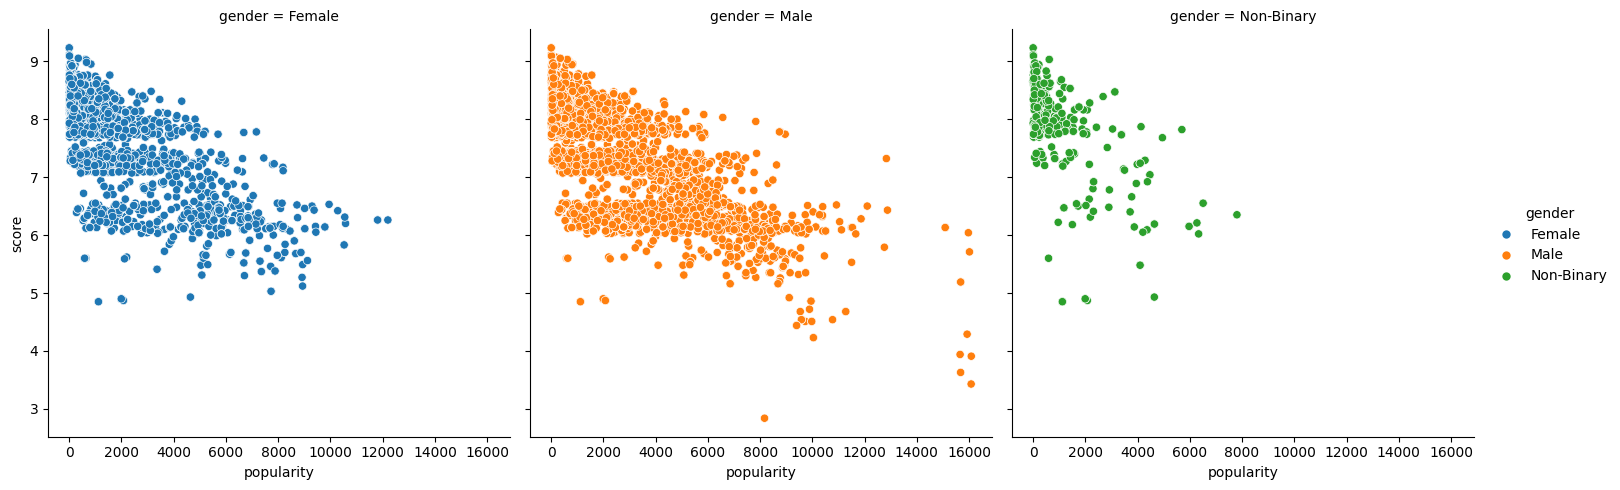

In [25]:
# Scatterplots
sns.relplot(y='score',x='popularity',data=sampled_data,col='gender',hue='gender')
plt.show()

## Feature Engineering
Converting 'Birthday' to Age

In [30]:
# Convert 'birthday' to datetime and then to age
current_year = datetime.now().year
sampled_data['age'] = sampled_data['birthday'].apply(lambda x: current_year - pd.to_datetime(x, errors='coerce').year)

# Sanity check
sampled_data.head()

,uid_review,profile,anime_uid,scores,Overall,Story,Animation,Sound,Character,Enjoyment,...,ranked,score,img_url,link_x,gender,birthday,favorites_anime,link_y,emotion_scores,age
0,27270,Elfsire,120,"{'Overall': '8', 'Story': '8', 'Animation': '1...",8,8,10,8,10,7,...,997.0,7.76,https://cdn.myanimelist.net/images/anime/4/752...,https://myanimelist.net/anime/120/Fruits_Basket,Female,"Mar 11, 1991","['14713', '14289', '4081', '14467', '16498', '...",https://myanimelist.net/profile/Elfsire,"{'anger': 0.010413373820483685, 'disgust': 0.0...",32.0
1,228044,merryfistmas,227,"{'Overall': '10', 'Story': '10', 'Animation': ...",10,10,10,10,10,10,...,493.0,8.06,https://cdn.myanimelist.net/images/anime/7/773...,https://myanimelist.net/anime/227/FLCL,Male,"Nov 22, 1993","['18679', '22135', '227', '23847', '5114', '11...",https://myanimelist.net/profile/merryfistmas,"{'anger': 0.18671022355556488, 'disgust': 0.00...",30.0
2,21744,ravenrage,3303,"{'Overall': '6', 'Story': '3', 'Animation': '8...",6,3,8,5,6,7,...,NaN,6.29,https://cdn.myanimelist.net/images/anime/11/41...,https://myanimelist.net/anime/3303/Momiji,Male,"Jan 4, 1990",['134'],https://myanimelist.net/profile/ravenrage,"{'anger': 0.007550527341663837, 'disgust': 0.0...",33.0
3,248039,Tyrannicswine117,32615,"{'Overall': '8', 'Story': '9', 'Animation': '8...",8,9,8,8,9,8,...,454.0,8.10,https://cdn.myanimelist.net/images/anime/5/828...,https://myanimelist.net/anime/32615/Youjo_Senki,Male,"Jul 25, 1997","['5114', '4181', '9253', '18679', '1', '2001',...",https://myanimelist.net/profile/Tyrannicswine117,"{'anger': 0.5558895468711853, 'disgust': 0.003...",26.0
4,215510,ThePunzalan,14813,"{'Overall': '9', 'Story': '9', 'Animation': '9...",9,9,9,9,10,9,...,453.0,8.10,https://cdn.myanimelist.net/images/anime/11/49...,https://myanimelist.net/anime/14813/Yahari_Ore...,Male,Apr 18,"['14813', '30831', '15809', '4224', '31715', '...",https://myanimelist.net/profile/ThePunzalan,"{'anger': 0.011294235475361347, 'disgust': 0.0...",NaN


### Exploring relationship between Ratings and Age by Gender

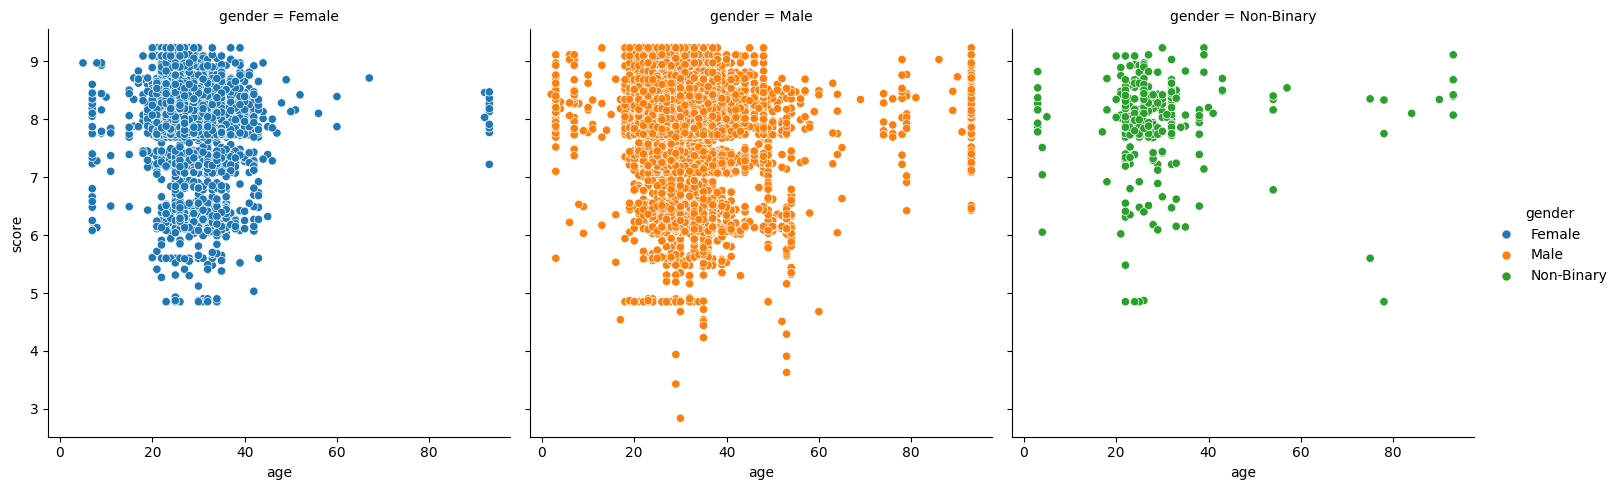

In [35]:
# Scatterplots
sns.relplot(y='score',x='age',data=sampled_data,col='gender',hue='gender')
plt.show()

### Data Distribution Visualizations
Using histograms, we'll plot the distributions of key numeric variables.

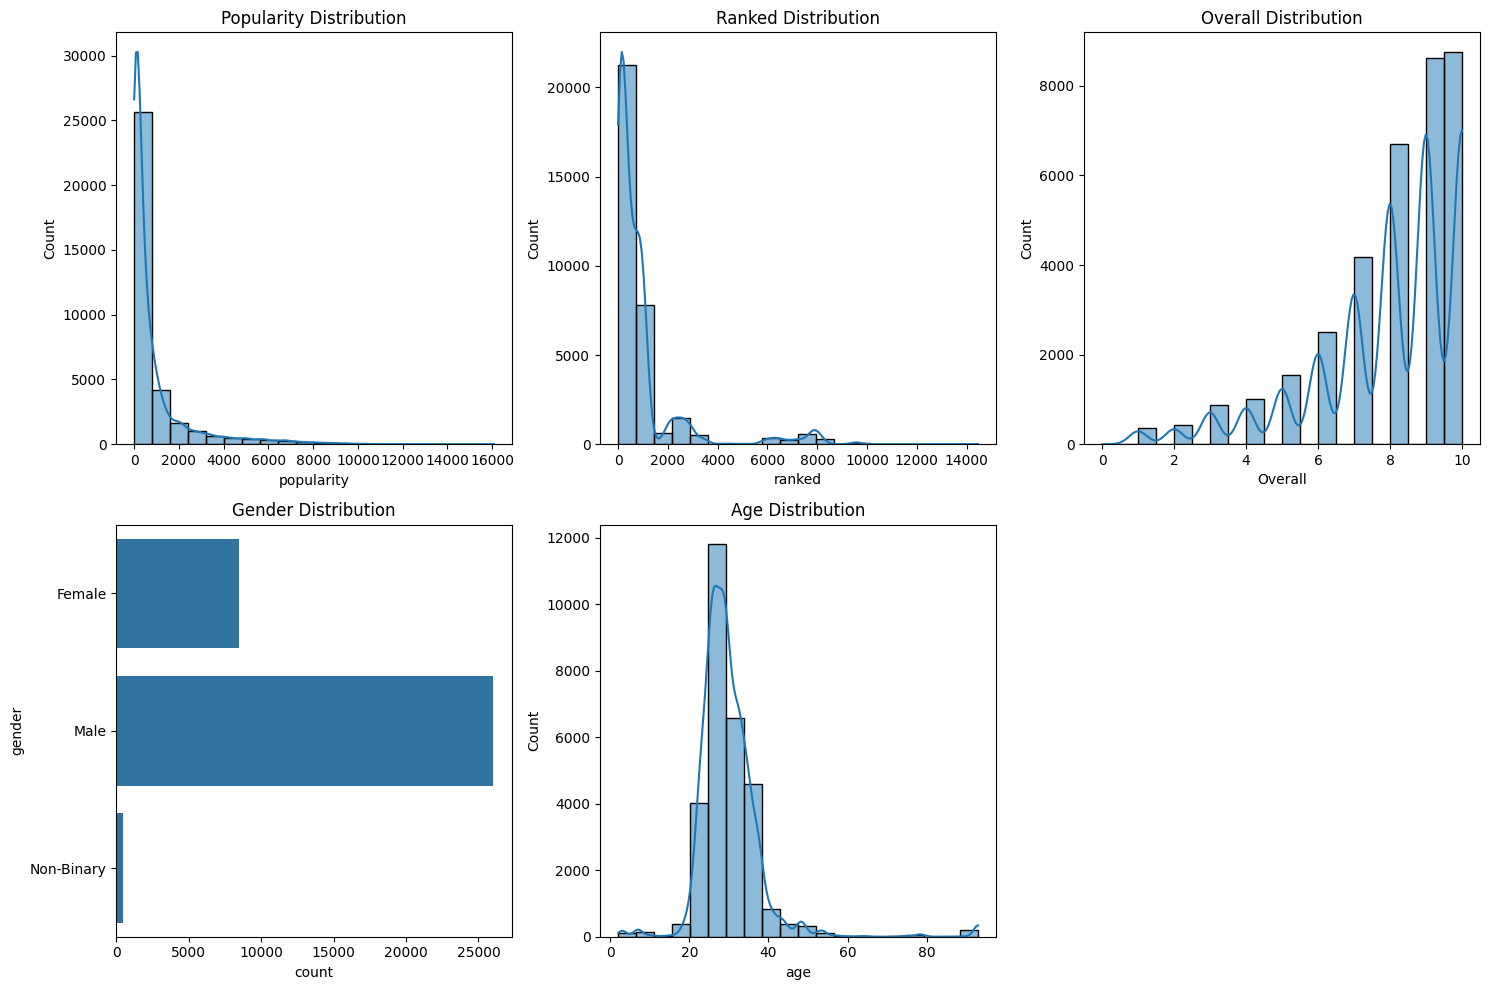

In [32]:
# Set fig size
plt.figure(figsize=(15, 10))

# Cfreate subplots for each column

# Popularity
plt.subplot(2, 3, 1)  # 2 rows, 3 columns, 1st subplot
sns.histplot(sampled_data['popularity'], bins=20, kde=True)
plt.title('Popularity Distribution')

# Ranked
plt.subplot(2, 3, 2)
sns.histplot(sampled_data['ranked'], bins=20, kde=True)
plt.title('Ranked Distribution')

# Overall
plt.subplot(2, 3, 3)
sns.histplot(sampled_data['Overall'], bins=20, kde=True)
plt.title('Overall Distribution')

# Gender
plt.subplot(2, 3, 4)
sns.countplot(sampled_data['gender'])
plt.title('Gender Distribution')

# Age
plt.subplot(2, 3, 5)
sns.histplot(sampled_data['age'], bins=20, kde=True)
plt.title('Age Distribution')


# Adjust layout spacing
plt.tight_layout()

plt.show()


<div style="text-align: center; border: 2px solid black;">
    <!-- Add padding to the div element -->
    <div style="padding: 20px 0;">
        <img src="images/K_G_Logo.png" alt="K&G Logo" width="150" height="150">
    </div>
</div>
<div align="center">
    <font size="1">Image by DALL-E</font>
</div>

## Maching Learning

### Emotion Classification in Texts with Natural Language Processing
Processing emotion classification in 'synopsis' data, leveraging NLP techniques and a pre-trained model.


In [40]:
# Download nltk stop words
nltk.download('stopwords')

# Load the emotion classification pipeline
model_name = "j-hartmann/emotion-english-distilroberta-base"
emotion_classifier = pipeline('text-classification', model=model_name, return_all_scores=True)

# Set English stop words
stop_words = set(stopwords.words('english'))

# Function for advanced text cleaning
def clean_text(text):
    text = text.lower()
    text = re.sub(r'<[^>]+>', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Function to classify emotions of a text
def classify_emotions(text):
    cleaned_text = clean_text(text)  # Clean the text using clean_text function
    predictions = emotion_classifier(cleaned_text)
    return {emotion['label']: emotion['score'] for emotion in predictions[0]}

# Apply the model to the 'synopsis' column
sampled_data['emotion_scores'] = sampled_data['synopsis'].astype(str).apply(classify_emotions)

# Inspect results
sampled_data[['synopsis', 'emotion_scores']].head()


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kariprimiano/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/kariprimiano/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/zg/2vpc_k5518g10mcclm90c_sw0000gn/T/ipykernel_82842/3834554372.py", line 26, in <module>
    sampled_data['emotion_scores'] = sampled_data['synopsis'].astype(str).apply(classify_emotions)
                                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/lib/python3.11/site-packages/pandas/core/series.py", line 4760, in apply
    convert_dtype=convert_dtype,
    ^^^^^^^
  File "/opt/homebrew/lib/python3.11/site-packages/pandas/core/apply.py", line 1207, in apply
  File "/opt/homebrew/lib/python3.11/site-packages/pandas/core/apply.py", line 1287, in apply_standard
    #  Categorical (GH51645).
             ^^^^^^^^^^^^^^^^
  File "/opt/homebrew/lib/python3.11/site-packages/pandas/core/base.py", li

In [58]:
sampled_data['emotion_scores'].value_counts

<bound method IndexOpsMixin.value_counts of 0        {'anger': 0.010413373820483685, 'disgust': 0.0...
1        {'anger': 0.18671022355556488, 'disgust': 0.00...
2        {'anger': 0.007550527341663837, 'disgust': 0.0...
3        {'anger': 0.5558895468711853, 'disgust': 0.003...
4        {'anger': 0.011294235475361347, 'disgust': 0.0...
                               ...                        
34983    {'anger': 0.0200864989310503, 'disgust': 0.000...
34984    {'anger': 0.007323819678276777, 'disgust': 0.0...
34985    {'anger': 0.005832878407090902, 'disgust': 0.0...
34986    {'anger': 0.004111292771995068, 'disgust': 0.0...
34987    {'anger': 0.022216347977519035, 'disgust': 0.0...
Name: emotion_scores, Length: 34988, dtype: object>

### Expanding 'emotion_scores' into separate columns

In [59]:
# Check if the emotion_scores column needs to be parsed from string to dictionary
if isinstance(sampled_data['emotion_scores'].iloc[0], str):
    sampled_data['emotion_scores'] = sampled_data['emotion_scores'].apply(ast.literal_eval)

# Expand the emotion_scores column into separate columns
emotion_scores = sampled_data['emotion_scores'].apply(pd.Series)

# Join the expanded emotion scores dataframe with the original data
data_with_emotions = sampled_data.join(emotion_scores)

# Display the first few rows to verify the expansion
data_with_emotions.head()


,uid_review,profile,anime_uid,scores,Overall,Story,Animation,Sound,Character,Enjoyment,...,link_y,emotion_scores,age,anger,disgust,fear,joy,neutral,sadness,surprise
0,27270,Elfsire,120,"{'Overall': '8', 'Story': '8', 'Animation': '1...",8,8,10,8,10,7,...,https://myanimelist.net/profile/Elfsire,"{'anger': 0.010413373820483685, 'disgust': 0.0...",32.0,0.010413,0.000746,0.197999,0.028194,0.013339,0.689401,0.059908
1,228044,merryfistmas,227,"{'Overall': '10', 'Story': '10', 'Animation': ...",10,10,10,10,10,10,...,https://myanimelist.net/profile/merryfistmas,"{'anger': 0.18671022355556488, 'disgust': 0.00...",30.0,0.186710,0.002664,0.069133,0.091217,0.139144,0.045635,0.465496
2,21744,ravenrage,3303,"{'Overall': '6', 'Story': '3', 'Animation': '8...",6,3,8,5,6,7,...,https://myanimelist.net/profile/ravenrage,"{'anger': 0.007550527341663837, 'disgust': 0.0...",33.0,0.007551,0.001111,0.001951,0.658758,0.077451,0.017352,0.235827
3,248039,Tyrannicswine117,32615,"{'Overall': '8', 'Story': '9', 'Animation': '8...",8,9,8,8,9,8,...,https://myanimelist.net/profile/Tyrannicswine117,"{'anger': 0.5558895468711853, 'disgust': 0.003...",26.0,0.555890,0.003051,0.173663,0.078683,0.091056,0.014780,0.082877
4,215510,ThePunzalan,14813,"{'Overall': '9', 'Story': '9', 'Animation': '9...",9,9,9,9,10,9,...,https://myanimelist.net/profile/ThePunzalan,"{'anger': 0.011294235475361347, 'disgust': 0.0...",NaN,0.011294,0.000683,0.000702,0.938779,0.007481,0.031252,0.009808


### Checking genres with highest emotion scores

In [60]:
# Calculate the percentage for each emotion
emotion_columns = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']
data_with_emotions[emotion_columns] = data_with_emotions[emotion_columns].div(data_with_emotions[emotion_columns].sum(axis=1), axis=0)

# Group by genre and calculate mean percentage for each emotion
genre_emotion_means = data_with_emotions.groupby('genre')[emotion_columns].mean()

# For each emotion, find the genre with the highest percentage
highest_emotion_genres = genre_emotion_means.idxmax()

print(highest_emotion_genres)


anger       ['Drama', 'Mystery', 'Sci-Fi', 'Supernatural',...
disgust              ['Hentai', 'Comedy', 'Magic', 'Romance']
fear        ['Mystery', 'Comedy', 'Horror', 'Demons', 'Psy...
joy                   ['Comedy', 'Ecchi', 'Harem', 'Romance']
neutral     ['Comedy', 'School', 'Shoujo Ai', 'Slice of Li...
sadness                    ['Drama', 'Historical', 'Shounen']
surprise    ['Comedy', 'Sports', 'Ecchi', 'School', 'Shoun...
dtype: object


### Saving new dataset with emotion scores

In [61]:
# Save new dataset
data_with_emotions.to_csv('zipped_data/data_with_emotions.csv')
data_with_emotions.head()

,uid_review,profile,anime_uid,scores,Overall,Story,Animation,Sound,Character,Enjoyment,...,link_y,emotion_scores,age,anger,disgust,fear,joy,neutral,sadness,surprise
0,27270,Elfsire,120,"{'Overall': '8', 'Story': '8', 'Animation': '1...",8,8,10,8,10,7,...,https://myanimelist.net/profile/Elfsire,"{'anger': 0.010413373820483685, 'disgust': 0.0...",32.0,0.010413,0.000746,0.197999,0.028194,0.013339,0.689401,0.059908
1,228044,merryfistmas,227,"{'Overall': '10', 'Story': '10', 'Animation': ...",10,10,10,10,10,10,...,https://myanimelist.net/profile/merryfistmas,"{'anger': 0.18671022355556488, 'disgust': 0.00...",30.0,0.186710,0.002664,0.069133,0.091217,0.139144,0.045635,0.465496
2,21744,ravenrage,3303,"{'Overall': '6', 'Story': '3', 'Animation': '8...",6,3,8,5,6,7,...,https://myanimelist.net/profile/ravenrage,"{'anger': 0.007550527341663837, 'disgust': 0.0...",33.0,0.007551,0.001111,0.001951,0.658758,0.077451,0.017352,0.235827
3,248039,Tyrannicswine117,32615,"{'Overall': '8', 'Story': '9', 'Animation': '8...",8,9,8,8,9,8,...,https://myanimelist.net/profile/Tyrannicswine117,"{'anger': 0.5558895468711853, 'disgust': 0.003...",26.0,0.555890,0.003051,0.173663,0.078683,0.091056,0.014780,0.082877
4,215510,ThePunzalan,14813,"{'Overall': '9', 'Story': '9', 'Animation': '9...",9,9,9,9,10,9,...,https://myanimelist.net/profile/ThePunzalan,"{'anger': 0.011294235475361347, 'disgust': 0.0...",NaN,0.011294,0.000683,0.000702,0.938779,0.007481,0.031252,0.009808


<div style="text-align: center; border: 2px solid black;">
    <!-- Add padding to the div element -->
    <div style="padding: 20px 0;">
        <img src="images/K_G_Logo.png" alt="K&G Logo" width="150" height="150">
    </div>
</div>
<div align="center">
    <font size="1">Image by DALL-E</font>
</div>

## Baseline Classification Model
- Classification Model for Mood Categorization
- Using anime_uid, title, genre, and popularity

### Rule-Based Labeling

In [43]:
def create_mood_label(row):
    if row['joy'] > 0.5:
        return 'Happy'
    elif row['sadness'] > 0.5:
        return 'Sad'
    elif row['anger'] > 0.5:
        return 'Angry'
    elif row['disgust'] > 0.5:
        return 'Disgust'
    elif row['fear'] > 0.5:
        return 'Fear'
    elif row['surprise'] > 0.5:
        return 'Excitement'
    else:
        return 'Neutral'

data_with_emotions['mood_label'] = data_with_emotions.apply(create_mood_label, axis=1)
data_with_emotions['mood_label'].value_counts()


mood_label
Fear          8975
Neutral       7069
Sad           5518
Happy         4686
Angry         4410
Excitement    4315
Disgust         15
Name: count, dtype: int64

### Preprocessing & Training

In [44]:
# Prepare the data - Features and Labels
X = data_with_emotions[['uid_anime', 'title', 'genre', 'popularity']]
y = data_with_emotions['mood_label']

numerical_feature = ['uid_anime', 'popularity']
categorical_feature = ['title', 'genre']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)


# Categorical feature preprocessing
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Numerical feature preprocessing with missing value handling
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])

# Combine preprocessing for different types of features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_feature),
        ('num', numerical_transformer, numerical_feature)
    ]
)

# Apply preprocessing
# We need to apply preprocessing to train and test sets separately
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

### Running Random Forest Classifier

In [45]:
# Initialize the classifier
classifier = RandomForestClassifier(random_state=13)

# Train the classifier with transformed training data
classifier.fit(X_train_transformed, y_train)

# Perform cross-validation
# Note: For cross-validation, you need to preprocess the entire dataset
X_transformed = preprocessor.fit_transform(X)
cross_val_scores = cross_val_score(classifier, X_transformed, y, cv=5)
print(f'Cross-Validation Scores: {cross_val_scores.mean():.2f}')

# Make predictions on the transformed test set
y_pred = classifier.predict(X_test_transformed)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy on Test Data: {accuracy:.2f}')

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:\n', cm)


Cross-Validation Scores: 0.98
Accuracy on Test Data: 0.98
Confusion Matrix:
 [[ 840    0    0    0    1   16    0]
 [   0    3    0    0    0    0    0]
 [   0    0  831    0    0   23    0]
 [   0    0    1 1756    1   21    0]
 [   0    0    0    0  936   29    0]
 [   1    0    0    0    2 1414    0]
 [   0    0    0    0    0   25 1098]]


## Tuning Classification Model Using Popularity & Genre

In [46]:
# Prepare the data - Features and Labels
X = data_with_emotions[['genre', 'popularity']]
y = data_with_emotions['mood_label']

numerical_feature = ['popularity']
categorical_feature = ['genre']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)


# Categorical feature preprocessing
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Numerical feature preprocessing with missing value handling
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])

# Combine preprocessing for different types of features
rfc_preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_feature),
        ('num', numerical_transformer, numerical_feature)
    ]
)

# Apply preprocessing
X_train_transformed = rfc_preprocessor.fit_transform(X_train)
X_test_transformed = rfc_preprocessor.transform(X_test)

### Saving Random Forest Classifier Preprocessing

In [ ]:
import joblib

# Save the preprocessor
joblib.dump(rfc_preprocessor, 'rfc_preprocessor.joblib')

In [ ]:
import pickle
# Saving with pickle
with open('rfc_preprocessor.pkl', 'wb') as file:
    pickle.dump(rfc_preprocessor, file)

# Loading with pickle
with open('rfc_preprocessor.pkl', 'rb') as file:
    rfc_preprocessor = pickle.load(file)


### Running Tuned Random Forest Classifier
To be used in the user-interface app

In [47]:
# Initialize the classifier
mood_classifier = RandomForestClassifier(random_state=13)

# Train the classifier with transformed training data
mood_classifier.fit(X_train_transformed, y_train)

# Perform cross-validation
# Note: For cross-validation, you need to preprocess the entire dataset
X_transformed = rfc_preprocessor.fit_transform(X)
cross_val_scores = cross_val_score(mood_classifier, X_transformed, y, cv=5)
print(f'Cross-Validation Scores: {cross_val_scores.mean():.2f}')

# Make predictions on the transformed test set
y_pred = mood_classifier.predict(X_test_transformed)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy on Test Data: {accuracy:.2f}')

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:\n', cm)


Cross-Validation Scores: 0.98
Accuracy on Test Data: 0.98
Confusion Matrix:
 [[ 840    0    1    0    2   12    2]
 [   0    3    0    0    0    0    0]
 [   1    0  832    0    1   20    0]
 [   1    0    2 1758    2   15    1]
 [   1    0    2    0  939   21    2]
 [   5    0    3    4    6 1398    1]
 [   0    0    0    1    1   22 1099]]


### Saving Random Forest Classifier Model
To be used in the user-interface app

In [ ]:
# Save the model
joblib.dump(mood_classifier, 'mood_classifier.joblib')

In [ ]:
import pickle
# Saving with pickle
with open('mood_classifier.pkl', 'wb') as file:
    pickle.dump(mood_classifier, file)

# Loading with pickle
with open('mood_classifier.pkl', 'rb') as file:
    mood_classifier = pickle.load(file)


## Interpretation

### Model Performance
The average cross-validation score is 0.98, which is extremely high. This score indicates the model's ability to generalize well over different subsets of the dataset. A high cross-validation score is desirable as it suggests consistent performance across different partitions of the data.

- The model achieved an accuracy of 0.98 on the test data, which aligns with the cross-validation score. This high accuracy suggests that the model is very effective in classifying the mood correctly.


- The Confusion Matrix shows a high true positive rate and a low false positive rate for most classes.


### Feature Used in Model
The high accuracy and cross-validation scores indicate that the model performs exceptionally well in mood classification. It suggests that Popularity and Genre are highly predictive of the mood.

### Conclusion
In summary, your RandomForestClassifier model shows excellent performance in mood classification with high accuracy and generalization capability. The features used, processed by the rfc_preprocessor, play a significant role in this high performance.


<div style="text-align: center; border: 2px solid black;">
    <!-- Add padding to the div element -->
    <div style="padding: 20px 0;">
        <img src="images/K_G_Logo.png" alt="K&G Logo" width="150" height="150">
    </div>
</div>
<div align="center">
    <font size="1">Image by DALL-E</font>
</div>


## Hybrid Deep Learning Models
Combine features from both content-based and collaborative filtering in a deep learning architecture, allowing the model to learn complex interactions between content and user preferences.

## Baseline Model

### Content-Based Filtering
Feature Extraction from Synopsis using TF-IDF

In [48]:
# Fill NaN values in 'synopsis' with empty string
data_with_emotions['synopsis'].fillna('', inplace=True)

# Split data
train_data, test_data = train_test_split(data_with_emotions, test_size=0.2, random_state=13)

# Apply TF-IDF to the training set and transform the test set
tfidf = TfidfVectorizer(stop_words='english')
train_content_features = tfidf.fit_transform(train_data['synopsis'])
test_content_features = tfidf.transform(test_data['synopsis'])

# Convert sparse TF-IDF matrix to a dense format for both train and test sets
train_content_features_dense = train_content_features.todense()
test_content_features_dense = test_content_features.todense()


### Prepare Collaborative Filtering Data
Prepare user-item interaction data and create embeddings for collaborative filtering

In [49]:
# Prepare user and item interaction data for both train and test sets
train_user_ids = train_data['uid_review'].astype('category').cat.codes.values
train_item_ids = train_data['anime_uid'].astype('category').cat.codes.values
test_user_ids = test_data['uid_review'].astype('category').cat.codes.values
test_item_ids = test_data['anime_uid'].astype('category').cat.codes.values

num_users = data_with_emotions['uid_review'].nunique()
num_items = data_with_emotions['anime_uid'].nunique()
embedding_size = 20

# Neural Collaborative Filtering model architecture
user_input = Input(shape=(1,))
item_input = Input(shape=(1,))
content_input = Input(shape=(train_content_features_dense.shape[1],))

user_embedding = Embedding(num_users, embedding_size, input_length=1)(user_input)
item_embedding = Embedding(num_items, embedding_size, input_length=1)(item_input)
user_vec = Flatten()(user_embedding)
item_vec = Flatten()(item_embedding)


### Hybrid Model Architecture
- Combine content-based and collaborative filtering features in a neural network

- Evaluate model with MAE

In [50]:
concatenated = concatenate([user_vec, item_vec, content_input])
dense_layer_1 = Dense(128, activation='relu')(concatenated)
output = Dense(1, activation='linear')(dense_layer_1)

model_hybrid = Model(inputs=[user_input, item_input, content_input], outputs=output)
model_hybrid.compile(optimizer=Adam(0.001), loss='mean_squared_error')

# Set a smaller batch size
batch_size = 32

# Train the Model
model_hybrid.fit(
    [train_user_ids, train_item_ids, train_content_features_dense],
    train_data['Overall'].values, 
    batch_size=batch_size, 
    epochs=5, 
    validation_split=0.1
)

# Evaluate the Model using MSE
mse_loss = model_hybrid.evaluate(
    [test_user_ids, test_item_ids, test_content_features_dense], 
    test_data['Overall'].values
)
print(f"Mean Squared Error on Test Data: {mse_loss}")

# Predict on the test data
test_predictions = model_hybrid.predict(
    [test_user_ids, test_item_ids, test_content_features_dense]
)

# Calculate MAE
mae_metric = MeanAbsoluteError()
mae_metric.update_state(test_data['Overall'].values, test_predictions)
mae = mae_metric.result().numpy()
print(f"Mean Absolute Error on Test Data: {mae}")


Epoch 1/5
788/788 [==============================] - 9s 11ms/step - loss: 7.5301 - val_loss: 2.9485
Epoch 2/5
788/788 [==============================] - 9s 11ms/step - loss: 1.4913 - val_loss: 2.4935
Epoch 3/5
788/788 [==============================] - 9s 11ms/step - loss: 0.6274 - val_loss: 2.3266
Epoch 4/5
788/788 [==============================] - 9s 11ms/step - loss: 0.3240 - val_loss: 2.2570
Epoch 5/5
219/219 [==============================] - 0s 1ms/step - loss: 5.9009
Mean Squared Error on Test Data: 5.900852203369141
219/219 [==============================] - 0s 1ms/step
Mean Absolute Error on Test Data: 1.8382927179336548


## Tuning Hybrid Model

- TF-IDF: Adjusted with parameters max_features and ngram_range.
- Regularization: Added L1 and L2 regularization to the first dense layer.
- Cross-Validation: Implemented with 5-fold cross

### Refine TF-IDF Features

In [73]:
# Fill NaN values in 'synopsis' with empty string
data_with_emotions['synopsis'].fillna('', inplace=True)

# Split data
train_data, test_data = train_test_split(data_with_emotions, test_size=0.2, random_state=13)

# Apply TF-IDF to the training set and transform the test set
tfidf = TfidfVectorizer(stop_words='english', max_features=1000, ngram_range=(1, 2))
train_content_features = tfidf.fit_transform(train_data['synopsis'])
test_content_features = tfidf.transform(test_data['synopsis'])

# Convert sparse TF-IDF matrix to a dense format for both train and test sets
train_content_features_dense = train_content_features.todense()
test_content_features_dense = test_content_features.todense()

In [74]:
# Prepare user and item interaction data for both train and test sets
train_user_ids = train_data['uid_review'].astype('category').cat.codes.values
train_item_ids = train_data['anime_uid'].astype('category').cat.codes.values
test_user_ids = test_data['uid_review'].astype('category').cat.codes.values
test_item_ids = test_data['anime_uid'].astype('category').cat.codes.values

num_users = data_with_emotions['uid_review'].nunique()
num_items = data_with_emotions['anime_uid'].nunique()
embedding_size = 20


### Model Architecture

In [75]:
# Define function to create the model
def create_model():
    user_input = Input(shape=(1,))
    item_input = Input(shape=(1,))
    content_input = Input(shape=(train_content_features_dense.shape[1],))

    user_embedding = Embedding(num_users, embedding_size, input_length=1)(user_input)
    item_embedding = Embedding(num_items, embedding_size, input_length=1)(item_input)
    user_vec = Flatten()(user_embedding)
    item_vec = Flatten()(item_embedding)

    concatenated = concatenate([user_vec, item_vec, content_input])
    dense_layer_1 = Dense(256, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(concatenated)
    dropout_1 = Dropout(0.3)(dense_layer_1)
    dense_layer_2 = Dense(128, activation='relu')(dropout_1)
    output = Dense(1, activation='linear')(dense_layer_2)

    model = Model(inputs=[user_input, item_input, content_input], outputs=output)
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
    return model

### Running Tuned Hybrid Model

In [76]:
# Define K-Fold Cross Validator
kfold = KFold(n_splits=5, shuffle=True, random_state=13)

# Convert features and labels to numpy arrays for indexing
train_user_ids = np.array(train_user_ids)
train_item_ids = np.array(train_item_ids)
train_content_features_dense = np.array(train_content_features_dense)
train_labels = np.array(train_data['Overall'].values)

# K-fold Cross Validation model evaluation
fold_no = 1
mae_scores=[]
for train_indices, test_indices in kfold.split(train_user_ids):
    # Split data
    X_train_user, X_test_user = train_user_ids[train_indices], train_user_ids[test_indices]
    X_train_item, X_test_item = train_item_ids[train_indices], train_item_ids[test_indices]
    X_train_content, X_test_content = train_content_features_dense[train_indices], train_content_features_dense[test_indices]
    y_train, y_test = train_labels[train_indices], train_labels[test_indices]

    # Create a new model instance
    model = create_model()
    
    # Fit data to model
    model.fit(
        [X_train_user, X_train_item, X_train_content],
        y_train, 
        batch_size=32, 
        epochs=10, 
        validation_split=0.1
    )
    
    # Evaluate the model
    scores = model.evaluate(
        [X_test_user, X_test_item, X_test_content],
        y_test
    )

print(f'MAE for fold {fold_no}: {scores[1]}')
mae_scores.append(scores[1])
fold_no += 1

# Calculate and print the average MAE across all folds
average_mae = sum(mae_scores) / len(mae_scores)
print(f'Average MAE across all folds: {average_mae}')

Epoch 1/10
630/630 [==============================] - 2s 3ms/step - loss: 12.9588 - mean_absolute_error: 1.7785 - val_loss: 5.1805 - val_mean_absolute_error: 1.3718
Epoch 2/10
630/630 [==============================] - 2s 3ms/step - loss: 4.5720 - mean_absolute_error: 1.1934 - val_loss: 4.7686 - val_mean_absolute_error: 1.2724
Epoch 3/10
630/630 [==============================] - 2s 3ms/step - loss: 2.8040 - mean_absolute_error: 0.8372 - val_loss: 3.9575 - val_mean_absolute_error: 1.1594
Epoch 4/10
630/630 [==============================] - 2s 3ms/step - loss: 2.0186 - mean_absolute_error: 0.6601 - val_loss: 3.6539 - val_mean_absolute_error: 1.1096
Epoch 5/10
630/630 [==============================] - 2s 3ms/step - loss: 1.6664 - mean_absolute_error: 0.5763 - val_loss: 3.4009 - val_mean_absolute_error: 1.0670
Epoch 6/10
630/630 [==============================] - 2s 3ms/step - loss: 1.5235 - mean_absolute_error: 0.5296 - val_loss: 3.5532 - val_mean_absolute_error: 1.1169
Epoch 7/10
630/

### Adjusting Tuned Model with Age & Gender Features
Neural network-based hybrid recommendation system model predicts how a user might rate an anime

### Preprocessing & Training

In [107]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse
import tensorflow as tf
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Flatten, Input, concatenate, Dense
from tensorflow.keras.regularizers import l1_l2

# Fill NaN values in 'synopsis' with empty string
data_with_emotions['synopsis'].fillna('', inplace=True)

# Define text preprocessing pipeline
text_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', max_features=1000, ngram_range=(1, 2)))
])

# Define numerical feature preprocessing
numerical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Define overall preprocessor
hybrid_preprocessor = ColumnTransformer(
    transformers=[
        ('text', text_pipeline, 'synopsis'),
        ('age', numerical_transformer, ['age']),
        ('gender', OneHotEncoder(), ['gender'])
    ]
)

# Split data
train_data, test_data = train_test_split(data_with_emotions, test_size=0.2, random_state=13)
train_transformed = hybrid_preprocessor.fit_transform(train_data)
test_transformed = hybrid_preprocessor.transform(test_data)

# Convert to dense array if it's a sparse matrix
if scipy.sparse.issparse(train_transformed):
    train_transformed = train_transformed.toarray()
if scipy.sparse.issparse(test_transformed):
    test_transformed = test_transformed.toarray()

# Prepare user and item IDs
train_user_ids = train_data['uid_review'].astype('category').cat.codes.values
train_item_ids = train_data['anime_uid'].astype('category').cat.codes.values
test_user_ids = test_data['uid_review'].astype('category').cat.codes.values
test_item_ids = test_data['anime_uid'].astype('category').cat.codes.values


### Saving Hybrid Regression Preprocessing

In [109]:
import joblib
# Save the preprocessor
joblib.dump(hybrid_preprocessor, 'hybrid_preprocessor.joblib')

['hybrid_preprocessor.joblib']

In [113]:
import pickle
# Saving with pickle
with open('hybrid_preprocessor.pkl', 'wb') as file:
    pickle.dump(hybrid_preprocessor, file)

# Loading with pickle
with open('hybrid_preprocessor.pkl', 'rb') as file:
    hybrid_preprocessor = pickle.load(file)


### Model Architecture

In [114]:
# Define model
def create_model(num_users, num_items, input_shape):
    user_input = Input(shape=(1,))
    item_input = Input(shape=(1,))
    additional_input = Input(shape=(input_shape,))

    # Make sure `input_dim` is set correctly
    user_embedding = Embedding(input_dim=num_users + 1, output_dim=20, input_length=1)(user_input)
    item_embedding = Embedding(input_dim=num_items + 1, output_dim=20, input_length=1)(item_input)
    user_vec = Flatten()(user_embedding)
    item_vec = Flatten()(item_embedding)

    concatenated = concatenate([user_vec, item_vec, additional_input])
    dense_layer = Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(concatenated)
    output = Dense(1, activation='linear')(dense_layer)

    model = Model(inputs=[user_input, item_input, additional_input], outputs=output)
    model.compile(optimizer=tf.keras.optimizers.legacy.Adam(0.0005), loss='mean_squared_error')
    return model


### Running Model

In [115]:
# K-Fold Cross Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=13)
mae_scores = []

for train_indices, test_indices in kfold.split(train_transformed):
    X_train, X_test = train_transformed[train_indices], train_transformed[test_indices]
    y_train, y_test = train_data.iloc[train_indices]['Overall'], train_data.iloc[test_indices]['Overall']
    train_user_ids_fold, test_user_ids_fold = train_user_ids[train_indices], train_user_ids[test_indices]
    train_item_ids_fold, test_item_ids_fold = train_item_ids[train_indices], train_item_ids[test_indices]

    # Create the model
    rating_predictor = create_model(np.max(train_user_ids_fold) + 1, np.max(train_item_ids_fold) + 1, X_train.shape[1])

    # Train the model
    history = rating_predictor.fit(
        [train_user_ids_fold, train_item_ids_fold, X_train],
        y_train,
        batch_size=32,
        epochs=10
    )

    # Predict and evaluate
    predictions = rating_predictor.predict([test_user_ids_fold, test_item_ids_fold, X_test])
    mae = mean_absolute_error(y_test, predictions)
    mae_scores.append(mae)
    print(f'Fold MAE: {mae}')

# Average MAE across all folds
average_mae = np.mean(mae_scores)
print(f'Average Mean Absolute Error across all folds: {average_mae}')

Epoch 1/10
700/700 [==============================] - 1s 1ms/step - loss: 23.2061
Epoch 2/10
700/700 [==============================] - 1s 2ms/step - loss: 4.7211
Epoch 3/10
700/700 [==============================] - 1s 1ms/step - loss: 3.7710
Epoch 4/10
700/700 [==============================] - 1s 1ms/step - loss: 2.6419
Epoch 5/10
700/700 [==============================] - 1s 1ms/step - loss: 1.8177
Epoch 6/10
700/700 [==============================] - 1s 1ms/step - loss: 1.3389
Epoch 7/10
700/700 [==============================] - 1s 2ms/step - loss: 1.0226
Epoch 8/10
700/700 [==============================] - 1s 1ms/step - loss: 0.8011
Epoch 9/10
700/700 [==============================] - 1s 1ms/step - loss: 0.6492
Epoch 10/10
175/175 [==============================] - 0s 319us/step
Fold MAE: 1.097838451965403
Epoch 1/10
700/700 [==============================] - 1s 1ms/step - loss: 24.3429
Epoch 2/10
700/700 [==============================] - 1s 1ms/step - loss: 4.8231
Epoch 3/10

### Saving Hybrid Recommendation System Model

In [118]:
# Save the model
joblib.dump(rating_predictor, 'saved_models/rating_predictor.joblib')

['saved_models/rating_predictor.joblib']

In [119]:
# Saving with pickle
with open('saved_models/rating_predictor.pkl', 'wb') as file:
    pickle.dump(rating_predictor, file)

# Loading with pickle
with open('saved_models/rating_predictor.pkl', 'rb') as file:
    rating_predictor = pickle.load(file)

## Interpretation

### Model Performance
- The average MAE across all folds is approx 1.1120. MAE of around 1.1120 indicates that this model predicts user Overall ratings, on average, within 1 rating point from the true value.

- Model's performance is relatively stable, indicated by the consistent MAE values for individual folds. The model is not highly dependent on specific segments of the data.

### Training Progress
- The training loss decreases consistently across epochs for each fold, starting from a high value (around 22-23) and reducing to less than 1 by the 10th epoch. This indicates that the model is learning from the training data and improving its predictive accuracy over time.

### Features Used in Model
- The model includes embeddings for users and items. These embeddings are critical in recommendation systems as they help in capturing the latent factors and interactions between users and items.

- The model also incorporates Age & Gender processed by the hybrid_preprocessor, possibly capturing demographic aspects related to users or items.

### Conclusion
The model shows consistent learning and a reasonable accuracy in predicting Overall ratings. However, must consider overfitting.

<div style="text-align: center; border: 2px solid black;">
    <!-- Add padding to the div element -->
    <div style="padding: 20px 0;">
        <img src="images/K_G_Logo.png" alt="K&G Logo" width="150" height="150">
    </div>
</div>
<div align="center">
    <font size="1">Image by DALL-E</font>
</div>

## User-interface Application
- See [MoodyManga](https://moody-manga-app-ginakari.streamlit.app/) for public-facing interactive app
- See Moody_Manga_App --> 'moody_manga_app.py' for completed app details

### Combining Recommendations Models

In [120]:
from joblib import load
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Embedding, Flatten, concatenate, Dense
from keras.regularizers import l2
from keras.optimizers import Adam

# Load pre-saved models and preprocessors
mood_classifier = load('saved_models/mood_classifier.joblib')
rfc_preprocessor = load('saved_models/rfc_preprocessor.joblib')
hybrid_preprocessor = load('saved_models/hybrid_preprocessor.joblib')

# Ensure 'gender' is categorical
data_with_emotions['gender'] = data_with_emotions['gender'].astype('category')

def sort_anime_based_on_predicted_ratings(data_with_emotions, user_age, user_gender, rating_predictor, hybrid_preprocessor):
    # Prepare additional input data
    additional_input_data = pd.DataFrame({
        'synopsis': data_with_emotions['synopsis'],
        'age': [user_age] * len(data_with_emotions),
        'gender': [user_gender] * len(data_with_emotions)
    })

    # Preprocess the additional input data
    additional_input_transformed = hybrid_preprocessor.transform(additional_input_data).todense()

    # Extract user and item IDs from the anime data
    user_ids = data_with_emotions['uid_review'].astype('category').cat.codes.values
    item_ids = data_with_emotions['anime_uid'].astype('category').cat.codes.values

    # Predict ratings using the rating predictor model
    predicted_ratings = rating_predictor.predict([user_ids, item_ids, additional_input_transformed])

    # Add the predicted ratings to the anime data
    data_with_emotions['predicted_rating'] = predicted_ratings

    # Sort the anime based on predicted ratings
    sorted_anime = data_with_emotions.sort_values(by='predicted_rating', ascending=False)

    return sorted_anime


def generate_playlist(mood, age, gender, data_with_emotions, mood_classifier, rating_predictor, rfc_preprocessor, hybrid_preprocessor):
    # Hardcoded mood-to-genre mapping
    mood_to_genre_mapping = {
        'Happy': ['Slice of Life', 'Comedy', 'Supernatural', 'Drama', 'Romance', 'Shoujo'],
        'Sad': ['Action', 'Drama', 'Military'],
        'Excited': ['Mystery', 'Police', 'Psychological', 'Supernatural', 'Thriller', 'Shounen'],
        'Angry': ['Action', 'Horror', 'Demons', 'Drama', 'Vampire', 'Shoujo'],
        # Add more mappings as needed
    }

    # Predict the mood for each anime
    features = data_with_emotions[['genre', 'popularity']]
    features_transformed = rfc_preprocessor.transform(features)
    data_with_emotions['predicted_mood'] = mood_classifier.predict(features_transformed)

    # Implement mood-based filtering
    genres_based_on_mood = mood_to_genre_mapping.get(mood, ['Default Genre'])
    average_popularity = data_with_emotions[data_with_emotions['genre'].isin(genres_based_on_mood)]['popularity'].mean()
    genres_str = ', '.join(genres_based_on_mood)
    mood_input_df = pd.DataFrame({'genre': [genres_str], 'popularity': [average_popularity]})
    mood_input_transformed = rfc_preprocessor.transform(mood_input_df)
    predicted_mood_category = mood_classifier.predict(mood_input_transformed)[0]
    filtered_anime = data_with_emotions[data_with_emotions['predicted_mood'] == predicted_mood_category]

    # Implement rating-based sorting
    sorted_anime = sort_anime_based_on_predicted_ratings(filtered_anime, age, gender, rating_predictor, hybrid_preprocessor)

    return sorted_anime.head(10)

# User Inputs - Replace with Python input() calls or hardcoded values for testing
user_mood = input('Select your mood (Happy, Sad, Excited, Angry, Fear, Neutral): ')
user_age = int(input('Enter your age (0-100): '))
user_gender = input('Select your gender (Male, Female, Non-Binary): ')

# Generate Playlist
playlist = generate_playlist(user_mood, user_age, user_gender, data_with_emotions, mood_classifier, rating_predictor, rfc_preprocessor, hybrid_preprocessor)

# Display Playlist
print(playlist[['title', 'synopsis', 'genre', 'predicted_mood', 'predicted_rating']])

224/224 [==============================] - 0s 383us/step
                                         title  \
28377                               Ergo Proxy   
22223                               Ergo Proxy   
20236        Otome Youkai Zakuro Picture Drama   
12578  Change!! Getter Robo: Sekai Saigo no Hi   
16063  Change!! Getter Robo: Sekai Saigo no Hi   
15791                         Samurai Champloo   
31900                               Ergo Proxy   
29362                               Ergo Proxy   
2467           Another: Misaki Mei - Shizukani   
8578           Another: Misaki Mei - Shizukani   

                                                synopsis  \
28377  Within the domed city of Romdo lies one of the...   
22223  Within the domed city of Romdo lies one of the...   
20236  Picture dramas included with the first and thi...   
12578  Dr. Saotome returns from the dead after being ...   
16063  Dr. Saotome returns from the dead after being ...   
15791  Fuu Kasumi is a young and

<div style="text-align: center; border: 2px solid black;">
    <!-- Add padding to the div element -->
    <div style="padding: 20px 0;">
        <img src="images/K_G_Logo.png" alt="K&G Logo" width="150" height="150">
    </div>
</div>
<div align="center">
    <font size="1">Image by DALL-E</font>
</div>

## Next Steps

- **More Emotions:** Train model on a larger selection of moods

- **Mood Mapping:** Expand genre-to-mood labeling

- **User Feedback:** Real-time user feedback to improve predictions and app functions

- **Image Classification:** Use img_url to process image data with Convolution Neural Networks to use for more advanced mood predictions

<div style="text-align: center; border: 2px solid black;">
    <!-- Add padding to the div element -->
    <div style="padding: 20px 0;">
        <img src="images/K_G_Logo.png" alt="K&G Logo" width="150" height="150">
    </div>
</div>
<div align="center">
    <font size="1">Image by DALL-E</font>
</div>

## Sources

### MyAnimeList:
- [Animes](https://www.kaggle.com/datasets/marlesson/myanimelist-dataset-animes-profiles-reviews/?select=animes.csv)

- [Profiles](https://www.kaggle.com/datasets/marlesson/myanimelist-dataset-animes-profiles-reviews/?select=profiles.csv)

- [Reviews](https://www.kaggle.com/datasets/marlesson/myanimelist-dataset-animes-profiles-reviews/?select=reviews.csv)

Related Referenced Sources:
- [azathoth42/myanimelist](https://www.kaggle.com/datasets/azathoth42/myanimelist)

- [CooperUnion/anime-recommendations-database](https://www.kaggle.com/datasets/CooperUnion/anime-recommendations-database)

- [natlee/myanimelist-comment-dataset](https://www.kaggle.com/datasets/natlee/myanimelist-comment-dataset)

- [MyAnimeList](https://myanimelist.net/)

### TMDB:
- [Anime](https://www.themoviedb.org/list/7102-anime)

### Top Anime
- [Top 10000 Anime Movies, OVA's and Tv-Shows](https://www.kaggle.com/datasets/thomaskonstantin/top-10000-anime-movies-ovas-and-tvshows)

### Outside Data:
- [NotifyVisitors](https://notifyvisitors.com)

This notebook was, of course, developed using knowledge from ChatGPT.

<div style="text-align: center; border: 2px solid black;">
    <!-- Add padding to the div element -->
    <div style="padding: 20px 0;">
        <img src="images/K_G_Logo.png" alt="K&G Logo" width="150" height="150">
    </div>
</div>
<div align="center">
    <font size="1">Image by DALL-E</font>
</div>

## About Us
**Kari Primiano**

- Tech Lead
- Email: kkprim@gmail.com
- github.com/kkprim

**Gina Guerin**

- Github & Presentation Lead
- Email: gina.b.guerin@gmail.com
- github.com/ginaguerin

<div style="text-align: center; border: 2px solid black;">
    <!-- Add padding to the div element -->
    <div style="padding: 20px 0;">
        <img src="images/K_G_Logo.png" alt="K&G Logo" width="150" height="150">
    </div>
</div>
<div align="center">
    <font size="1">Image by DALL-E</font>
</div>